In [0]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,cifar10
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Input, Concatenate, AveragePooling2D,Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical

In [2]:
choose_dataset = 1
choose_normalization = 2

if choose_dataset == 1:
  #Loading MNIST dataset
  (train_data,train_labels),(test_data,test_labels) = mnist.load_data()
  train_data = train_data.reshape((train_data.shape[0],28,28,1))
  test_data = test_data.reshape((test_data.shape[0],28,28,1))
else:
  #Loading CIFAR10 dataset
  (train_data,train_labels),(test_data,test_labels) = cifar10.load_data()

if choose_normalization == 1:
  #Scaling 1
  #Normalize to range of 0-1 
  train_data = train_data.astype('float32') /255.0
  test_data = test_data.astype('float32') / 255.0

else:
  #Scaling 2 Colab crashes
  #Standardization for zero mean and unit variance
  mean = train_data.mean()
  std_dev = train_data.std()

  train_data = train_data.astype('float32')
  test_data = test_data.astype('float32')
  train_data = (train_data-mean)/std_dev
  test_data = (test_data-mean)/std_dev

#One hot encode the numerical labels
train_labels = to_categorical(train_labels,num_classes=10)
test_labels = to_categorical(test_labels,num_classes=10) 

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#Divide training data into training and validation
split = int(0.1*train_data.shape[0])
X_train = train_data[split:]
X_val = train_data[:split]
Y_train = train_labels[split:]
Y_val = train_labels[:split]

In [0]:
#MODEL 2
#VGG11 Implementation

input_layer = Input(shape=(train_data.shape[1],train_data.shape[2],train_data.shape[3]))

#resize_layer = Lambda(lambda x: tf.image.resize(x,(224,224)))(input_layer)
conv1_layer = Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same',activation='relu')(input_layer)
maxpool1_layer = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(conv1_layer)

conv2_layer = Conv2D(filters=128,kernel_size=(3,3),strides=1,padding='same',activation='relu')(maxpool1_layer)
maxpool2_layer = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(conv2_layer)

conv3_layer = Conv2D(filters=256,kernel_size=(3,3),strides=1,padding='same',activation='relu')(maxpool2_layer)
conv3_layer = Conv2D(filters=256,kernel_size=(3,3),strides=1,padding='same',activation='relu')(conv3_layer)
maxpool3_layer = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(conv3_layer)

conv4_layer = Conv2D(filters=512,kernel_size=(3,3),strides=1,padding='same',activation='relu')(maxpool3_layer)
conv4_layer = Conv2D(filters=512,kernel_size=(3,3),strides=1,padding='same',activation='relu')(conv4_layer)
maxpool4_layer = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(conv4_layer)

conv5_layer = Conv2D(filters=512,kernel_size=(3,3),strides=1,padding='same',activation='relu')(maxpool4_layer)
conv5_layer = Conv2D(filters=512,kernel_size=(3,3),strides=1,padding='same',activation='relu')(conv5_layer)
maxpool5_layer = MaxPool2D(pool_size=(2,2),strides=2,padding='same')(conv5_layer)

FC_layer = Flatten()(maxpool5_layer)
FC_layer = Dense(units=4096,activation='relu')(FC_layer)
FC_layer = Dropout(rate=0.5)(FC_layer)
FC_layer = Dense(units=4096,activation='relu')(FC_layer)
FC_layer = Dropout(rate=0.5)(FC_layer)

output_layer = Dense(units=10,activation='softmax')(FC_layer)

model = Model(inputs=input_layer,outputs=output_layer)
model.compile(optimizer=optimizers.SGD(learning_rate=0.01,momentum=0.9),
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

In [0]:
training_history = []

In [8]:
batch_size = 256
history = model.fit(x=X_train,
                    y=Y_train,
                    validation_data=(X_val,Y_val),
                    epochs=10,
                    batch_size=256
                    )
training_history.append(history)

Epoch 1/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0124 - accuracy: 0.9964 - val_loss: 0.0478 - val_accuracy: 0.9885
Epoch 2/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0112 - accuracy: 0.9963 - val_loss: 0.0469 - val_accuracy: 0.9897
Epoch 3/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.0399 - val_accuracy: 0.9902
Epoch 4/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0480 - val_accuracy: 0.9902
Epoch 5/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0472 - val_accuracy: 0.9897
Epoch 6/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0495 - val_accuracy: 0.9897
Epoch 7/10
211/211 [==============================] - 8s 36ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0449 - val_accuracy: 0.9898

In [0]:
#Training with data augmentation
datagen = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.2)
datagen.fit(X_train)

In [29]:
batch_size=256
history = model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),
                              steps_per_epoch=math.ceil(X_train.shape[0]/batch_size),
                              validation_data=(X_val,Y_val),
                              epochs=20)
training_history.append(history)

Epoch 1/20
176/176 [==============================] - 19s 110ms/step - loss: 0.2879 - accuracy: 0.9010 - val_loss: 0.4833 - val_accuracy: 0.8462
Epoch 2/20
176/176 [==============================] - 19s 109ms/step - loss: 0.2812 - accuracy: 0.9034 - val_loss: 0.4983 - val_accuracy: 0.8444
Epoch 3/20
176/176 [==============================] - 19s 111ms/step - loss: 0.2803 - accuracy: 0.9027 - val_loss: 0.4652 - val_accuracy: 0.8544
Epoch 4/20
176/176 [==============================] - 19s 109ms/step - loss: 0.2650 - accuracy: 0.9072 - val_loss: 0.4275 - val_accuracy: 0.8676
Epoch 5/20
176/176 [==============================] - 19s 109ms/step - loss: 0.2626 - accuracy: 0.9096 - val_loss: 0.4877 - val_accuracy: 0.8532
Epoch 6/20
176/176 [==============================] - 19s 109ms/step - loss: 0.2503 - accuracy: 0.9136 - val_loss: 0.4815 - val_accuracy: 0.8526
Epoch 7/20
176/176 [==============================] - 19s 109ms/step - loss: 0.2360 - accuracy: 0.9175 - val_loss: 0.4708 - val_ac

In [0]:
#Saving model
model.save('GoogleNetMNIST.h5')

In [9]:
model.evaluate(test_data,[test_labels,test_labels,test_labels],batch_size=256,verbose=1)

40/40 [==============================] - 1s 14ms/step - loss: 0.0367 - accuracy: 0.9916


[0.03673188015818596, 0.991599977016449]

In [33]:
len(train_accuracy)

80

In [0]:
#Plotting for GoogleNet
import matplotlib.pyplot as plt
import matplotlib

train_accuracy = []
validation_accuracy = []
loss = []
for i in training_history:
  loss += i.history['loss']
  train_accuracy += i.history['accuracy']
  validation_accuracy += i.history['val_accuracy']

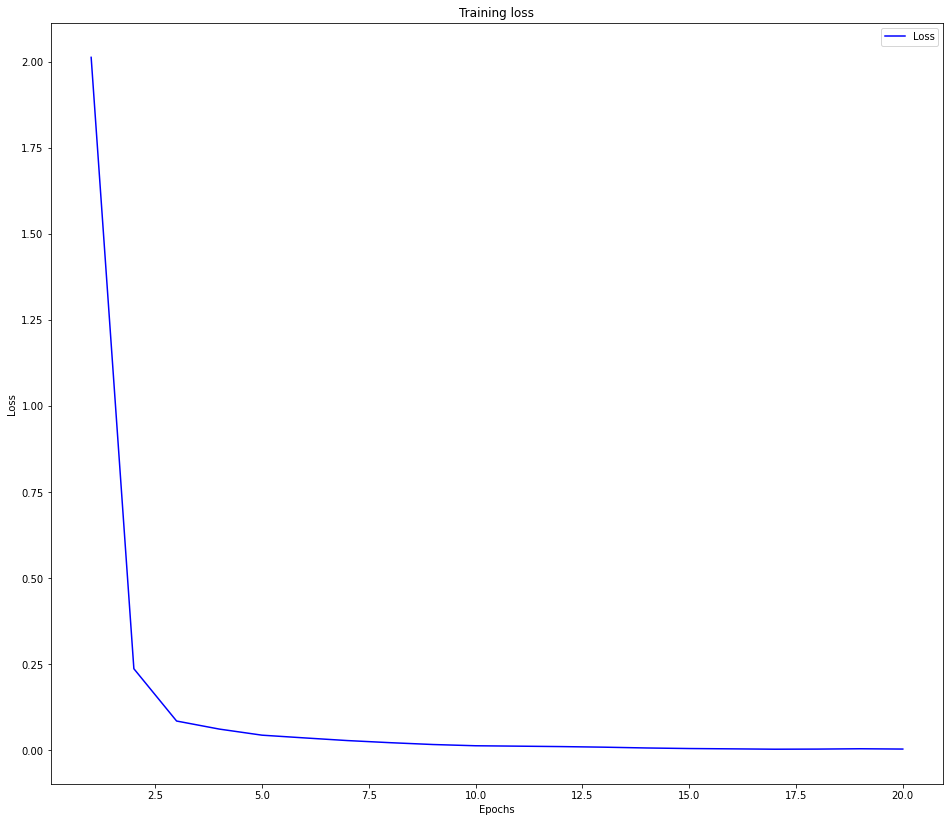

In [12]:
#Plot Training losses for output,aux1 output and aux2 output
matplotlib.rcParams['figure.figsize'] = [16.0,14.0]
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, loss, 'b', label='Loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('VGGMNISTLoss.png')
plt.show()

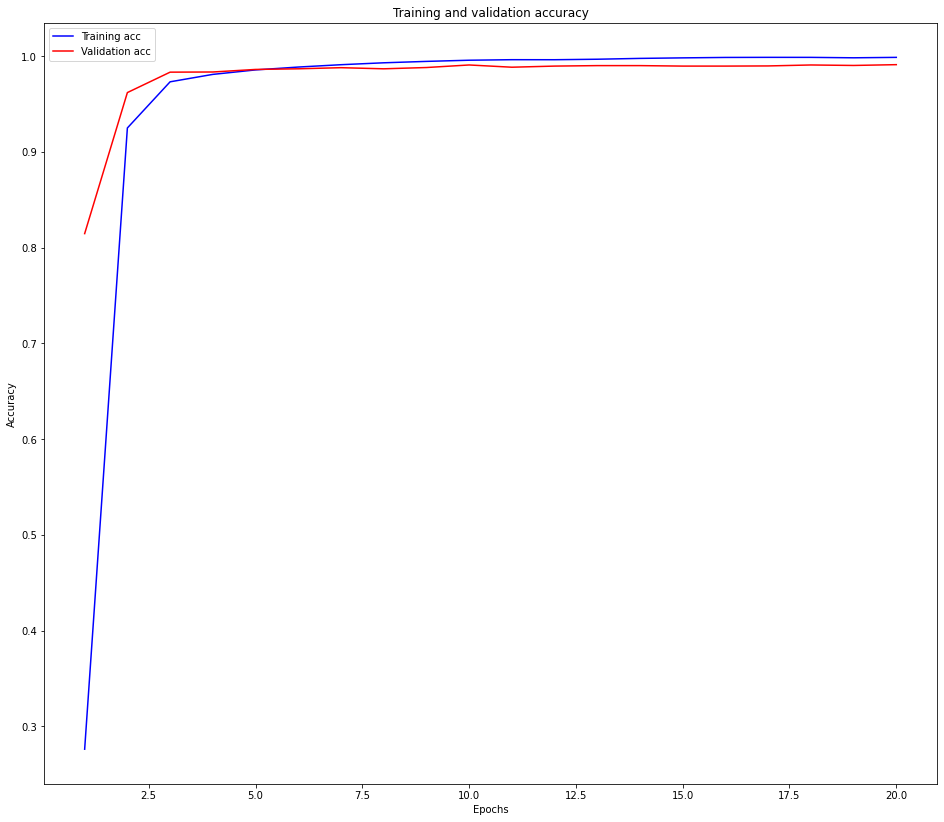

In [13]:
#Plot train and validation accuracy
matplotlib.rcParams['figure.figsize'] = [16.0,14.0]
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training acc')
plt.plot(epochs, validation_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('VGGMNISTAccuracy.png')
plt.show()